**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Prepare the data](#toc2_)    
- 3. [Model](#toc3_)    
- 4. [Training & Evaluation](#toc4_)    
- 5. [Driver Code](#toc5_)    
  - 5.1. [Standalone](#toc5_1_)    
  - 5.2. [Predict function](#toc5_2_)    
  - 5.3. [Hyperparameter Tuning](#toc5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

In [167]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pprint import pprint
import yfinance as yf
import datetime as dt
import shap

In [2]:
# get GOOGL Tweet data
googl_tweet = pd.read_parquet('googl_tweet_data.gzip') 
googl_tweet .head()
sentiments = googl_tweet.groupby('date')['compound_score'].mean()

In [3]:
df_tweets = pd.read_parquet('googl_tweet_data.gzip') 
df_reddits = pd.read_csv("reddit_sentiments.csv")
df_newss = pd.read_csv("news_sentiments.csv")

sentiments_tweet = df_tweets.groupby('date')['compound_score'].mean()
df_tweet = pd.DataFrame(sentiments_tweet)

sentiments_reddit = df_reddits.groupby('Date')['reddit_compound'].mean()
df_reddit = pd.DataFrame(sentiments_reddit)

sentiments_news = df_newss.groupby('date')['news_compound'].mean()
df_news = pd.DataFrame(sentiments_news)

df_tweet.rename(columns = {'compound_score':'tweet_compound'}, inplace = True)

df_tweet = df_tweet.reset_index()
df_reddit = df_reddit.reset_index()
df_news = df_news.reset_index()

df_tweet['date'] = pd.to_datetime(df_tweet['date'])
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])
df_news['date'] = pd.to_datetime(df_news['date'])

# 2. <a id='toc2_'></a>[Prepare the data](#toc0_)

In [224]:
def prepare_data_multivariate(df, choosen_stock, startdate, enddate, features, look_back, train_days=-1, predict_type='year'):
    # Choose specific stock
    data = df[df["Stock"] == choosen_stock]

    # Testing split
    if predict_type=='year':
        test_data = data[data["Date"].dt.year == 2019]
    elif predict_type=='month':
        test_data = data[(data["Date"].dt.year == 2019) & (data["Date"].dt.month.isin([1]))]
    elif predict_type=='days':
        test_data = data[data["Date"].dt.year == 2019][0:20] 
        # test_data = data[(data["Date"] >= "2019-01-01") & (data["Date"] <= "2019-01-16")]
    else:
        test_data = data[(data["Date"] >= dt.datetime(2023, 11, 12)) & (data["Date"] <= enddate)]
        test_data = 
        
        
    
    if(train_days==-1):
        # Training split: data for years 2015-2018
        # train_data = data[data["Date"].dt.year.isin(range(2015, 2019))]
        train_data = data[(data["Date"] >= startdate) & (data["Date"] <= dt.datetime(2023, 11, 11))]
        # valid_size = int(len(data) * 0.10)
        # train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]
       
    else:
        # Extract the date range for training data based on the test data
        train_end_date = test_data["Date"].min() - pd.DateOffset(days=1)
        train_start_date = train_end_date - pd.DateOffset(days=train_days)
        train_data = data[(data["Date"] >= train_start_date) & (data["Date"] <= train_end_date)]
        valid_size = int(len(data) * 0.02)
        train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]
    
    # Feature selection and engineering
    train_data = train_data[features + ["Date"]].values
    # valid_data = valid_data[features + ["Date"]].values
    test_data = test_data[features + ["Date"]].values
    
    
    
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data[:, :-1] = scaler.fit_transform(train_data[:, :-1])
    # valid_data[:, :-1] = scaler.transform(valid_data[:, :-1])
    test_data[:, :-1] = scaler.transform(test_data[:, :-1])
    
    print(train_data.shape)
    print(test_data.shape)
    
    # Create sequences for LSTM input
    def create_sequences(dataset, look_back=1):
        X, Y, dates = [], [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), :-1])
            Y.append(dataset[i + look_back, 0])
            dates.append(dataset[i + look_back, -1])  # Assuming the last column is 'Date'
            
            
        return np.array(X), np.array(Y), np.array(dates)

    train_X, train_Y, train_dates = create_sequences(train_data, look_back)
    # valid_X, valid_Y, valid_dates = create_sequences(valid_data, look_back)
    test_X, test_Y, test_dates = create_sequences(test_data, look_back)
    # print(test_Y.shape)

    # Convert data to PyTorch tensors
    train_X = torch.Tensor(train_X.astype(np.float32))
    train_Y = torch.Tensor(train_Y)
    # valid_X = torch.Tensor(valid_X.astype(np.float32))
    # valid_Y = torch.Tensor(valid_Y)
    test_X = torch.Tensor(test_X.astype(np.float32))
    test_Y = torch.Tensor(test_Y)
    
    return train_X, train_Y, train_dates, test_X, test_Y, test_dates, scaler, test_data # test_data, # valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates,

# 3. <a id='toc3_'></a>[Model](#toc0_)

In [17]:
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 4. <a id='toc4_'></a>[Training & Evaluation](#toc0_)

In [219]:
def train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, test_data, visualize=True):
    # Initialize the model
    model = MultivariateLSTMModel(input_size, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Training the model
    train_losses = []
    # val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs.view(-1), train_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        model.eval()
        # val_outputs = model(valid_X)
        # val_loss = criterion(val_outputs.view(-1), valid_Y)
        # val_losses.append(val_loss.item())
        
        # if visualize == True:
        #     if (epoch + 1) % 20 == 0:
        #         print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    model.eval()
    
    print(train_X.shape)
    print(test_X.shape)
    
    # Calculate predictions
    train_predict = model(train_X).view(-1).cpu().detach().numpy()
    # valid_predict = model(valid_X).view(-1).cpu().detach().numpy()
    test_predict = model(test_X).view(-1).cpu().detach().numpy()
    
    # Compute MAPE
    train_mape = mean_absolute_percentage_error(train_Y, train_predict)
    # valid_mape = mean_absolute_percentage_error(valid_Y, valid_predict)
    test_mape = mean_absolute_percentage_error(test_Y, test_predict)

    # Evaluate the model using metrics like mean squared error (MSE)
    train_rmse = mean_squared_error(train_Y, train_predict, squared=False)
    # valid_rmse = mean_squared_error(valid_Y, valid_predict, squared=False)
    test_rmse = mean_squared_error(test_Y, test_predict, squared=False)
    
    # 1.
    # scaler --> test_data[:, :-1]
    test_data1 = test_data[:, :-1]
    # # Get the shape of the first array
    shape_to_match = test_predict.reshape(-1, 1).shape
    # # Ensure the second array has the same number of rows as the first array
    test_data1 = test_data1[:, 1:]
    test_data1 = test_data1[:shape_to_match[0], :]
    # # Append the arrays
    test_data1 = np.hstack((test_predict.reshape(-1, 1), test_data1)) 
    test_predict_inverse = scaler.inverse_transform(test_data1)[:,0]
    
    # 2.
    test_data2 = test_data[:, :-1]
    test_data2 = test_data2[:shape_to_match[0], :]
    test_Y_inverse = scaler.inverse_transform(test_data2)[:,0]
    
    # if visualize == True:
        
    # #     # 1. Visualize training and validation loss
    # #     plt.figure(figsize=(10, 5))
    # #     plt.plot(train_losses, label='Training Loss', linewidth=2)
    # #     plt.plot(val_losses, label='Validation Loss', linewidth=2)
    # #     plt.title("Training and Validation Loss Over Epochs")
    # #     plt.xlabel("Epoch")
    # #     plt.ylabel("Loss")
    # #     plt.legend()
    # #     plt.grid(True)
    # #     plt.show()

    #     # # 2. Visualize test and predictions
    #     # plt.figure(figsize=(10, 5))
    #     # plt.plot(test_dates, test_Y_inverse, label='True', linewidth=2)
    #     # plt.plot(test_dates, test_predict_inverse, label='Predicted', linewidth=2)
    #     # plt.title("Test vs. Predicted Prices")
    #     # plt.xlabel("Date")
    #     # plt.ylabel("Price")
    #     # plt.legend()
    #     # plt.xticks(rotation=45)
    #     # plt.grid(True)
    #     # plt.show()
    
    return model, loss, train_rmse, test_rmse, train_mape, test_mape, test_Y_inverse, test_predict_inverse 

# 5. <a id='toc5_'></a>[Driver Code](#toc0_)

## 5.1. <a id='toc5_1_'></a>[Standalone](#toc0_)

In [19]:
# Load the data
yf.pdr_override() # Override pandas datareader with yfinance
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT'] # list of stock symbols
startdate = dt.datetime(2015, 1, 1) # start date
enddate = dt.datetime(2020, 12, 31) # end date
df = yf.download(y_symbols, start=startdate, end=enddate) # Retrieve historical stock price data for the specified symbols and date range
df = df.stack(level=1) # Stack the multi-level index to create a single-level index
df = df.reset_index() # Reset the index to make 'Date' a regular column
df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # Rename the columns to match the desired structure
df['Date'] = pd.to_datetime(df['Date'])

[*********************100%%**********************]  5 of 5 completed


In [280]:
# # Amey's code
# df_sentiments = pd.DataFrame(sentiments)
# df_sentiments.reset_index(inplace = True)
# df_sentiments.date = pd.to_datetime(df_sentiments.date)
# df_sentiments.head()

# # Merge
# df_final = df.merge(df_sentiments, left_on='Date', right_on='date')
# df_final.head()

# df_final.describe()

In [20]:
df = df.merge(df_tweet, left_on= 'Date', right_on='date', how='left')
# df = df.merge(df_reddit, left_on = 'Date', right_on='Date',  how='left')
# df = df.merge(df_news, left_on = 'Date', right_on='date', how='left')

# print(df.shape)

# print("Total no of rows in stock data: 1510")
# print("Number of missing values in Reddit:  848")
# print("Number of missing values in Tweets:  252")
# print("Number of missing values in News:  1187")

# print(filtered_df.columns)

In [268]:
df['all_compound'] = np.nan

# Check conditions and fill the 'new_column' accordingly
conditions = [
    df['tweet_compound'].isnull() & df['reddit_compound'].isnull() & df['news_compound'].isnull(),  # All three columns are NaN
    (~df['tweet_compound'].isnull()) & df['reddit_compound'].isnull() & df['news_compound'].isnull(),  # Only 'tweet' has a value
    df['tweet_compound'].isnull() & (~df['reddit_compound'].isnull()) & df['news_compound'].isnull(),  # Only 'Reddit' has a value
    df['tweet_compound'].isnull() & df['reddit_compound'].isnull() & (~df['news_compound'].isnull()),  # Only 'news' has a value
    (~df['tweet_compound'].isnull()) & (~df['reddit_compound'].isnull()) & df['news_compound'].isnull(),  # 'tweet' and 'Reddit' have values
    (~df['tweet_compound'].isnull()) & df['reddit_compound'].isnull() & (~df['news_compound'].isnull()),  # 'tweet' and 'news' have values
    df['tweet_compound'].isnull() & (~df['reddit_compound'].isnull()) & (~df['news_compound'].isnull()),  # 'Reddit' and 'news' have values
    (~df['tweet_compound'].isnull()) & (~df['reddit_compound'].isnull()) & (~df['news_compound'].isnull())  # All three columns have values
]

choices = [
    np.nan,  # Fill NaN if all three columns are NaN
    df['tweet_compound'],  # Fill with 'tweet' value
    df['reddit_compound'],  # Fill with 'Reddit' value
    df['news_compound'],  # Fill with 'news' value
    (df['tweet_compound'] + df['reddit_compound']) / 2,  # Fill with mean of 'tweet' and 'Reddit'
    (df['tweet_compound'] + df['news_compound']) / 2,  # Fill with mean of 'tweet' and 'news'
    (df['reddit_compound'] + df['news_compound']) / 2,  # Fill with mean of 'Reddit' and 'news'
    (df['tweet_compound'] + df['reddit_compound'] + df['news_compound']) / 3  # Fill with mean of all three columns
]

df['all_compound'] = np.select(conditions, choices, default=np.nan)

In [21]:
nan_count = df['tweet_compound'].isnull().sum()
print("Number of NaN values in 'new_column':", nan_count)

df['tweet_compound'] = df['tweet_compound'].ffill()

filtered_df = df[df['Stock']=='GOOG']

nan_count = filtered_df['tweet_compound'].isna().sum()
print("Number of NaN values in 'new_column':", nan_count)

filtered_df.head()

# filtered_df.dropna(inplace=True)

Number of NaN values in 'new_column': 1260
Number of NaN values in 'new_column': 0


,Date,Stock,Adj Close,Close,High,Low,Open,Volume,date,tweet_compound
2,2015-01-02,GOOG,26.168653,26.168653,26.490770,26.133251,26.378078,28951268,2015-01-02,0.155139
7,2015-01-05,GOOG,25.623152,25.623152,26.144720,25.582764,26.091366,41196796,2015-01-05,0.307565
12,2015-01-06,GOOG,25.029282,25.029282,25.738087,24.983908,25.679497,57998800,2015-01-06,0.302669
17,2015-01-07,GOOG,24.986401,24.986401,25.292759,24.914099,25.280592,41301082,2015-01-07,0.261704
22,2015-01-08,GOOG,25.065184,25.065184,25.105074,24.482782,24.831326,67071641,2015-01-08,0.212186


In [170]:
# choose stock and lags
choosen_stock = "GOOG"
look_back = 5
train_days = -1
predict_type = 'year'

train_X, train_Y, train_dates, valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates, scaler, test_data = prepare_data_multivariate(filtered_df, choosen_stock, features=['Close', 'High', 'Low', 'Open', 'Volume', 'tweet_compound'], look_back=look_back)

# Define hyperparameters
input_size = 6  # Number of input features (High, Low, Open, Close, Volume)
hidden_sizes = 64  # Number of hidden units in the LSTM
num_layers = 1  # Number of LSTM layers
output_size = 1  # Number of output features (Close price)
learning_rate = 0.02
num_epochs = 100

# Create the model
model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape, test_Y, test_predict = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, test_data, visualize=True)

print(model)
print("test_rmse: ", round(test_rmse, 5))
print("test_mape: ", round(test_mape, 5))

TypeError: prepare_data_multivariate() missing 2 required positional arguments: 'startdate' and 'enddate'

**Observations:**

- Training and Validation loss decreases over the epochs.

- Predictions are more accurate for shorter timeframes with more accuracy in predicting immediately following dates.

unrecognized nn.Module: LSTM


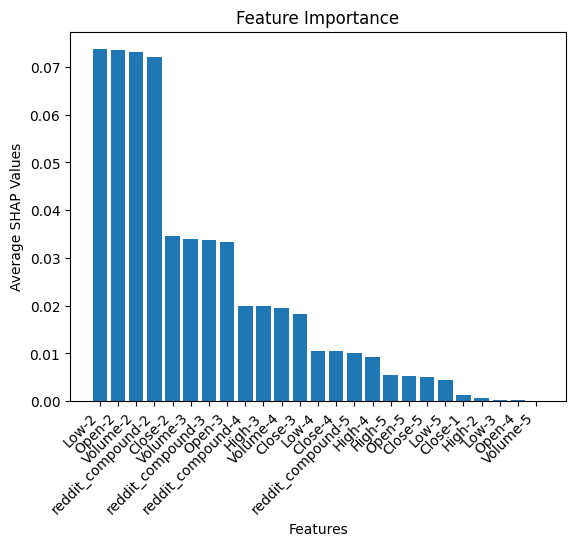

In [12]:
# Feature importances
explainer = shap.DeepExplainer(model, train_X)
shap_values = explainer.shap_values(test_X, check_additivity=False)

# Extract feature names and create a dictionary
feature_names = ['Close', 'High', 'Low', 'Open', 'Volume', 'reddit_compound']
lag_names = [f'{feature}-{i}' for i in range(look_back,0,-1) for feature in feature_names]
shap_dict = {}

k=0
for i in range(0,5):
    for j in range(0,5):
        shap_dict[lag_names[k]] = shap_values[:, i, j].mean()
        k = k+1

# Sort the dictionary by values
sorted_shap_dict = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))

# Create a bar chart
plt.bar(sorted_shap_dict.keys(), sorted_shap_dict.values())
plt.xlabel('Features')
plt.ylabel('Average SHAP Values')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()


# Create a summary plot for all features
# shap.summary_plot(shap_values, test_X, plot_type='bar')
 
# Create a summary plot for a specific class (for regression, use index 0)
# shap.summary_plot(shap_values[0], test_X)

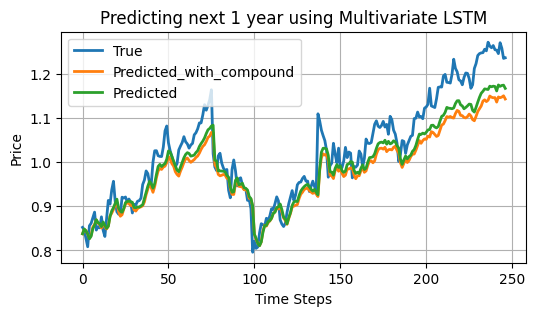

In [87]:
# updated code Nidhi

np.random.seed(42)

# Exclude 'all_compound' feature from the list of features
features_no_compound = ['Close', 'High', 'Low', 'Open', 'Volume']

# Prepare data without the 'all_compound' feature
train_X_no_compound, train_Y_no_compound, train_dates, valid_X_no_compound, valid_Y_no_compound, valid_dates, test_X_no_compound, test_Y_no_compound, test_dates, scaler_no_compound = prepare_data_multivariate(filtered_df, choosen_stock, features=features_no_compound, look_back=look_back)


# Create and train the model without 'all_compound' feature
model_no_compound, loss_no_compound, train_rmse_no_compound, valid_rmse_no_compound, test_rmse_no_compound, train_mape_no_compound, valid_mape_no_compound, test_mape_no_compound,test_Y_no, test_predict_no = train_evaluate_lstm_multivariate(5, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X_no_compound, train_Y_no_compound, valid_X_no_compound, valid_Y_no_compound, test_X_no_compound, test_Y_no_compound, scaler_no_compound, visualize=False)

# 2. Visualize test and predictions
plt.figure(figsize=(6, 3))
plt.plot(test_Y, label='True', linewidth=2)
plt.plot(test_predict, label='Predicted_with_compound', linewidth=2)
plt.plot(test_predict_no, label='Predicted', linewidth=2)
plt.title("Predicting next 1 year using Multivariate LSTM")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# # 2. Visualize test and predictions
# plt.figure(figsize=(10, 5))
# plt.plot(test_dates, test_Y, label='True', linewidth=2)
# plt.plot(test_dates, test_predict, label='Predicted', linewidth=2)
# plt.title("Test vs. Predicted Prices")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.show()

## 5.2. <a id='toc5_2_'></a>[Predict function](#toc0_)

In [274]:
def load_data(choosen_stock):    
    yf.pdr_override() # Override pandas datareader with yfinance
    y_symbols = [choosen_stock, 'DSST']
    startdate = dt.datetime(2019, 1, 1) # start date
    enddate = dt.datetime(2023, 11, 30) # end date # +1
    df = yf.download(y_symbols, start=startdate, end=enddate) # Retrieve historical stock price data for the specified symbols and date range
    df = df.stack(level=1) # Stack the "multi-level index to create a single-level index
    df = df.reset_index() # Reset the index to make 'Date' a regular column
    df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] #Rename the columns to match the desired structure
    df['Date'] = pd.to_datetime(df['Date'])
    return df, startdate, enddate

In [316]:
def predict(choosen_stock):

    look_back = 1
    train_days = -1
    predict_type = 'predict'
    df, startdate, enddate = load_data(choosen_stock)
    data = df[df["Stock"] == choosen_stock] 
    #data['Date'] = pd.to_datetime(data['Date'])
    print(data.tail())
    print(data.info())
    print(data['Date'].values)
    # Append the last row to the DataFrame
    new_row = {'Date':'2019-01-02T00:00:00.000000000', 'Stock':'META' , 'Adj Close': 0.0, 'Close': 0.0 , 'High': 0.0,'Low': 0.0, 'Open':0.0, 'Volume':0.0}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    data = data.append(new_row, ignore_index=True)
    print(data.tail())
    

    features = ['Close', 'High', 'Low', 'Open', 'Volume']

    train_X, train_Y, train_dates, test_X, test_Y, test_dates, scaler, test_data = prepare_data_multivariate(data, choosen_stock, startdate, enddate, features=features, look_back=look_back, predict_type=predict_type )
    
    # print(test_X.shape)
    # print(train_dates.shape)
    print(test_dates)
    
    # print(train_X.shape)
    # print(train_Y.shape)
    
    # Define hyperparameters
    input_size = 5  # Number of input features (High, Low, Open, Close, Volume)
    hidden_sizes = 64  # Number of hidden units in the LSTM
    num_layers = 1  # Number of LSTM layers
    output_size = 1  # Number of output features (Close price)
    learning_rate = 0.02
    num_epochs = 100

    # Create the model
    model, loss, train_rmse, test_rmse, train_mape, test_mape, test_Y_inverse, test_predict_inverse  = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, test_data, visualize=False)
    
    

    # Formatting the prices to a desired decimal form
    formatted_test_Y = ["{:.4f}".format(price) for price in test_Y_inverse.flatten()]
    formatted_test_predict = ["{:.4f}".format(price) for price in test_predict_inverse.flatten()]

    return formatted_test_Y, formatted_test_predict

In [317]:
actual_prices, predicted_prices = predict('META')
print(actual_prices)
print(predicted_prices)
# print(train_dates.shape)
# print(test_dates.shape)

[*********************100%%**********************]  2 of 2 completed


1 Failed download:
['DSST']: Exception('%ticker%: No timezone found, symbol may be delisted')



           Date Stock   Adj Close       Close        High         Low  \
1229 2023-11-17  META  335.040009  335.040009  335.500000  329.350006   
1230 2023-11-20  META  339.970001  339.970001  341.869995  334.190002   
1231 2023-11-21  META  336.980011  336.980011  339.899994  335.899994   
1232 2023-11-22  META  341.489990  341.489990  342.920013  338.579987   
1233 2023-11-24  META  338.230011  338.230011  341.855591  336.769989   

            Open      Volume  
1229  330.260010  14494400.0  
1230  334.890015  16960500.0  
1231  338.329987  12027900.0  
1232  339.209991  10702700.0  
1233  340.130005   5467488.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1234 non-null   datetime64[ns]
 1   Stock      1234 non-null   object        
 2   Adj Close  1234 non-null   float64       
 3   Close      1234 non-null   f

AttributeError: 'DataFrame' object has no attribute 'append'

## 5.3. <a id='toc5_3_'></a>[Hyperparameter Tuning](#toc0_)

In [13]:
## Tuning

# # Load the data
# yf.pdr_override() # Override pandas datareader with yfinance
# y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']
# startdate = dt.datetime(2015, 1, 1) # start date
# enddate = dt.datetime(2020, 12, 31) # end date
# df = yf.download(y_symbols, start=startdate, end=enddate) # Retrieve historical stock price data for the specified symbols and date range
# df = df.stack(level=1) # Stack the multi-level index to create a single-level index
# df = df.reset_index() # Reset the index to make 'Date' a regular column
# df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # Rename the columns to match the desired structure
# df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
choosen_stock = "GOOG"  # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back_values = [5] 
hidden_size_values = [64, 128] 

num_layers_values = [1] # [2, 3, 4]
learning_rate_values = [0.005, 0.01, 0.02]  
num_epochs = 100
years_to_include = [2015, 2016, 2017, 2018, 2019]

train_days_values = [-1, 60, 100, 365, 365*2]
predict_type = 'year'

best_models = []
top_k = 3  # Get the top k performing models

# Hyperparameter tuning loop
for look_back in look_back_values:
    for hidden_size in hidden_size_values:
        for num_layers in num_layers_values:
            for learning_rate in learning_rate_values:
                # print(f"\nHyperparameters: look_back={look_back}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}")
                train_X, train_Y, train_dates, valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates, scaler = prepare_data_multivariate(filtered_df, choosen_stock, features=['High', 'Low', 'Open', 'Close', 'Volume', 'tweet_compound'], look_back=10)
                model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape, test_Y, test_predict = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=False)
                best_models.append({
                    "look_back": look_back,
                    "model" : model,
                    "learning_rate": learning_rate,
                    "train_days": train_days,
                    # "train_rmse": train_rmse,
                    # "valid_rmse": valid_rmse,
                    "test_rmse": test_rmse,
                    # "train_mape": train_mape,
                    # "valid_mape": valid_mape,
                    "test_mape": test_mape,
                })

# Sort the models by RMSE in ascending order
best_models.sort(key=lambda x: (x["test_rmse"], x["test_mape"]))

# Print the top-k performing models
print(f"\nTop {top_k} Performing Models:")
pprint(best_models[:top_k])


Top 3 Performing Models:
[{'learning_rate': 0.02,
  'look_back': 5,
  'model': MultivariateLSTMModel(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
),
  'test_mape': 0.029372275,
  'test_rmse': 0.040368542,
  'train_days': -1},
 {'learning_rate': 0.005,
  'look_back': 5,
  'model': MultivariateLSTMModel(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
),
  'test_mape': 0.031091254,
  'test_rmse': 0.041500814,
  'train_days': -1},
 {'learning_rate': 0.02,
  'look_back': 5,
  'model': MultivariateLSTMModel(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
),
  'test_mape': 0.030402105,
  'test_rmse': 0.04180188,
  'train_days': -1}]


**Observations:**

- Hyperparameter tuning results in top k models having almost similar performance.

In [14]:
best_models[0]

{'look_back': 5,
 'model': MultivariateLSTMModel(
   (lstm): LSTM(6, 64, batch_first=True)
   (fc): Linear(in_features=64, out_features=1, bias=True)
 ),
 'learning_rate': 0.02,
 'train_days': -1,
 'test_rmse': 0.040368542,
 'test_mape': 0.029372275}

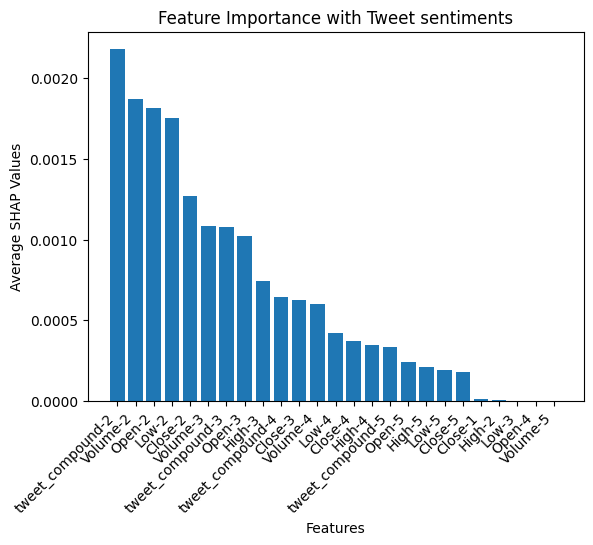

In [17]:
# Feature importances
explainer = shap.DeepExplainer(best_models[0]['model'], train_X)
shap_values = explainer.shap_values(test_X, check_additivity=False)

# Extract feature names and create a dictionary
feature_names = ['Close', 'High', 'Low', 'Open', 'Volume', 'tweet_compound']
lag_names = [f'{feature}-{i}' for i in range(look_back,0,-1) for feature in feature_names]
shap_dict = {}

k=0
for i in range(0,5):
    for j in range(0,5):
        shap_dict[lag_names[k]] = shap_values[:, i, j].mean()
        k = k+1

# Sort the dictionary by values
sorted_shap_dict = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))

# Create a bar chart
# plt.figsize(12,6)
plt.bar(sorted_shap_dict.keys(), sorted_shap_dict.values())
plt.xlabel('Features')
plt.ylabel('Average SHAP Values')
plt.title('Feature Importance with Tweet sentiments')
plt.xticks(rotation=45, ha='right')
plt.show()


# Create a summary plot for all features
# shap.summary_plot(shap_values, test_X, plot_type='bar')
 
# Create a summary plot for a specific class (for regression, use index 0)
# shap.summary_plot(shap_values[0], test_X)

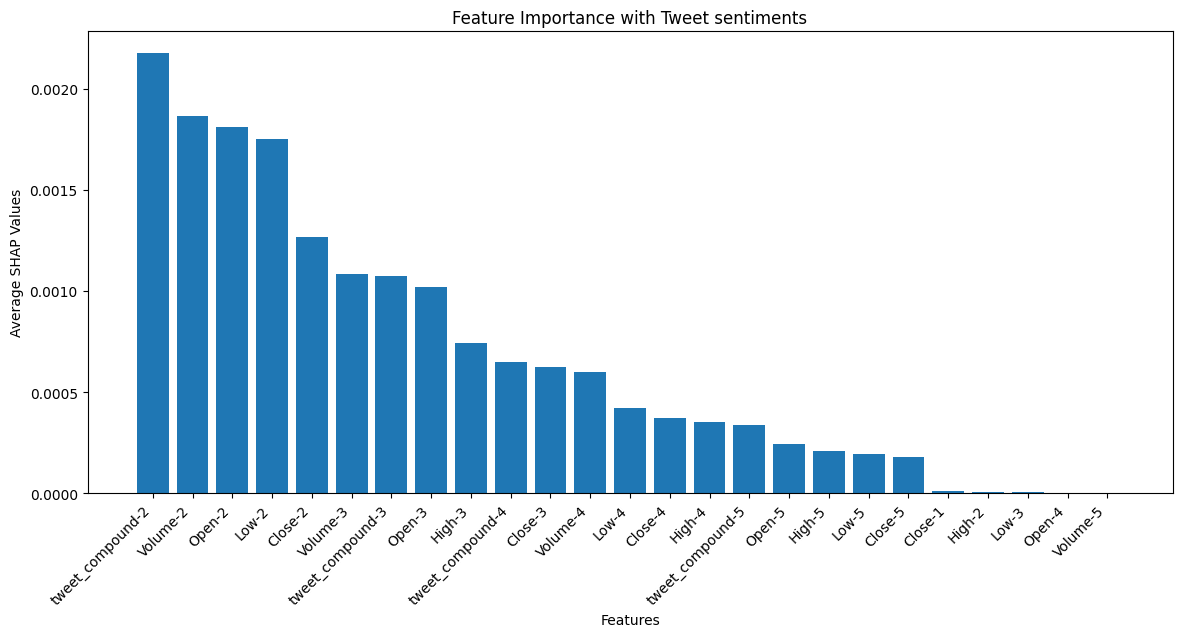

In [26]:
# Create a bar chart
plt.figure(figsize=(14,6))
plt.bar(sorted_shap_dict.keys(), sorted_shap_dict.values())
plt.xlabel('Features')
plt.ylabel('Average SHAP Values')
plt.title('Feature Importance with Tweet sentiments')
plt.xticks(rotation=45, ha='right')
plt.show()

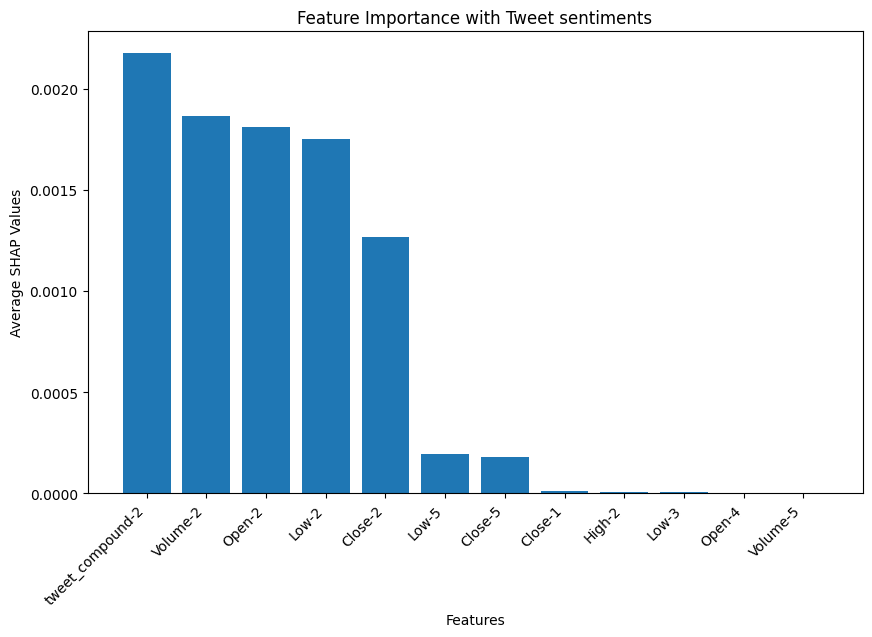

In [29]:
# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(list(sorted_shap_dict.keys())[:5] + list(sorted_shap_dict.keys())[-7:], list(sorted_shap_dict.values())[:5] + list(sorted_shap_dict.values())[-7:])
plt.xlabel('Features')
plt.ylabel('Average SHAP Values')
plt.title('Feature Importance with Tweet sentiments')
plt.xticks(rotation=45, ha='right')
plt.show()